# Visualisation of gridded Lightning Imager (LI) products
<br> 
<br> 
<br> 
Blanka Gvoždíková, Jindřich Šťástka <br> 
blanka.gvozdikova@chmi.cz

- Based on September 2021 LI test data release
- point / gridded
- gridded flash accumulations within FCI 2km grid in 30 s time interval
<br> 
<br> 
- 3 types of accumulations:
 - Accumulated flash area
 - Accumulated flash?
 - Accumulated flash radiance

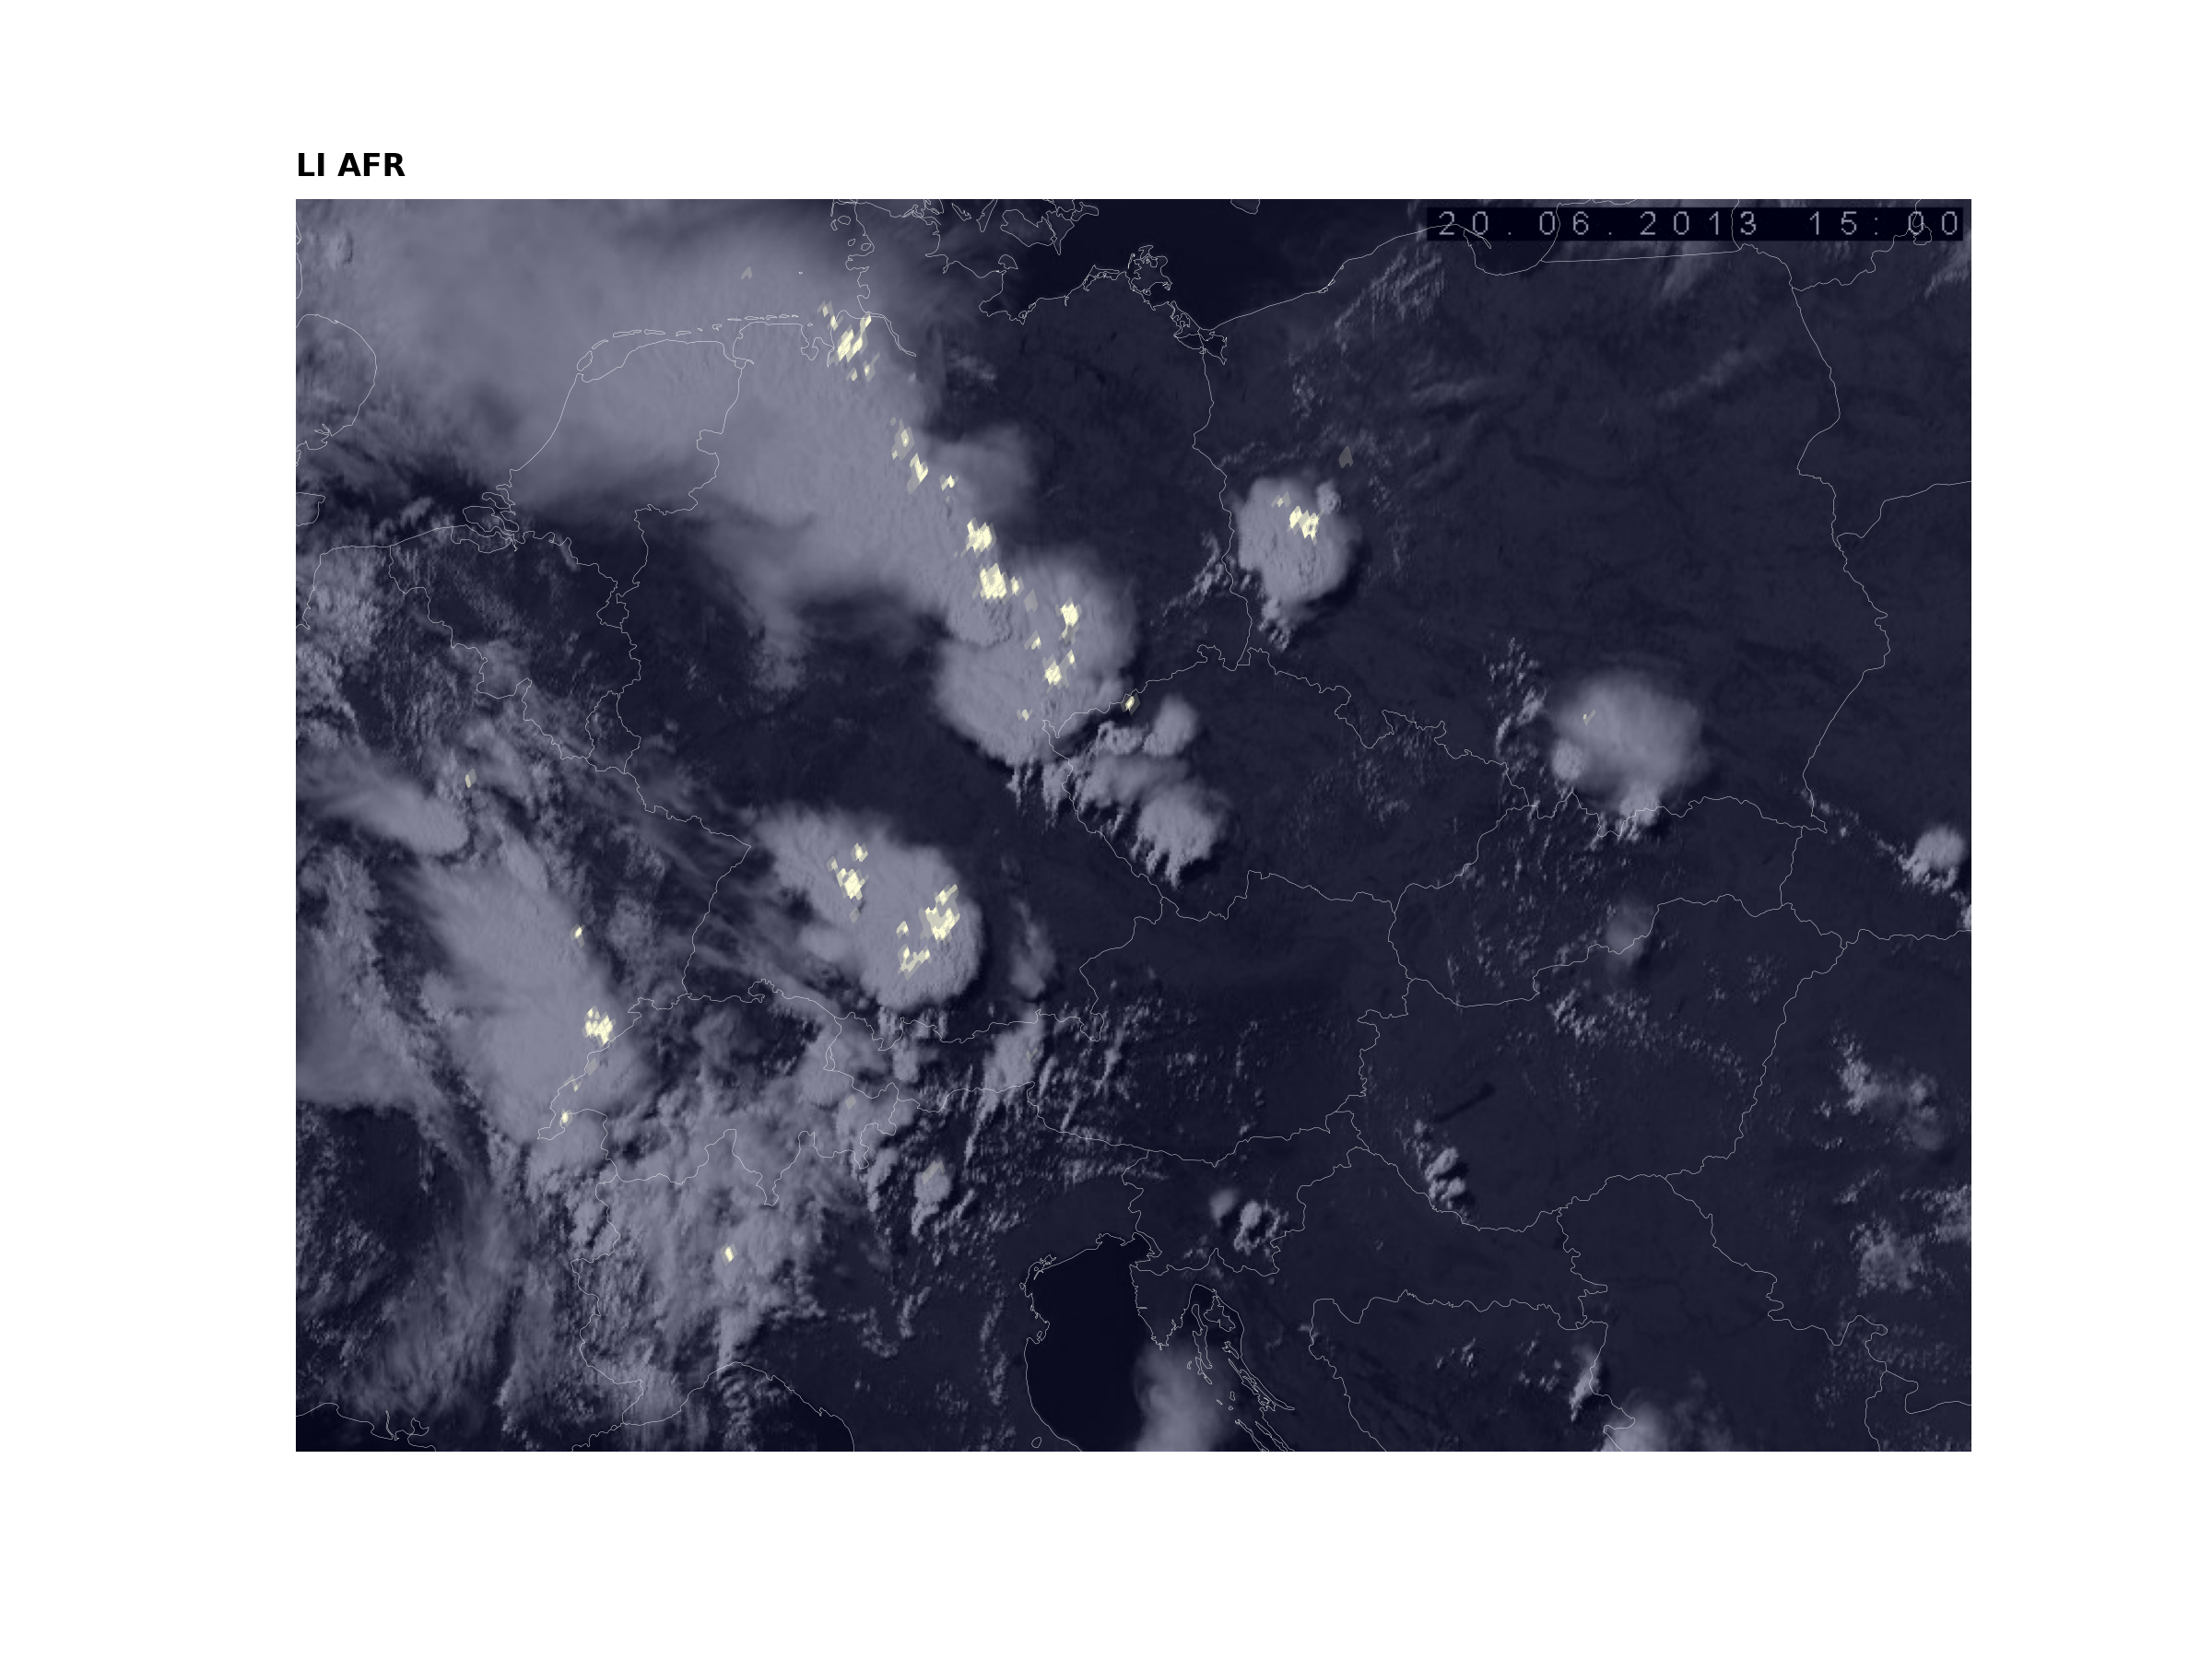

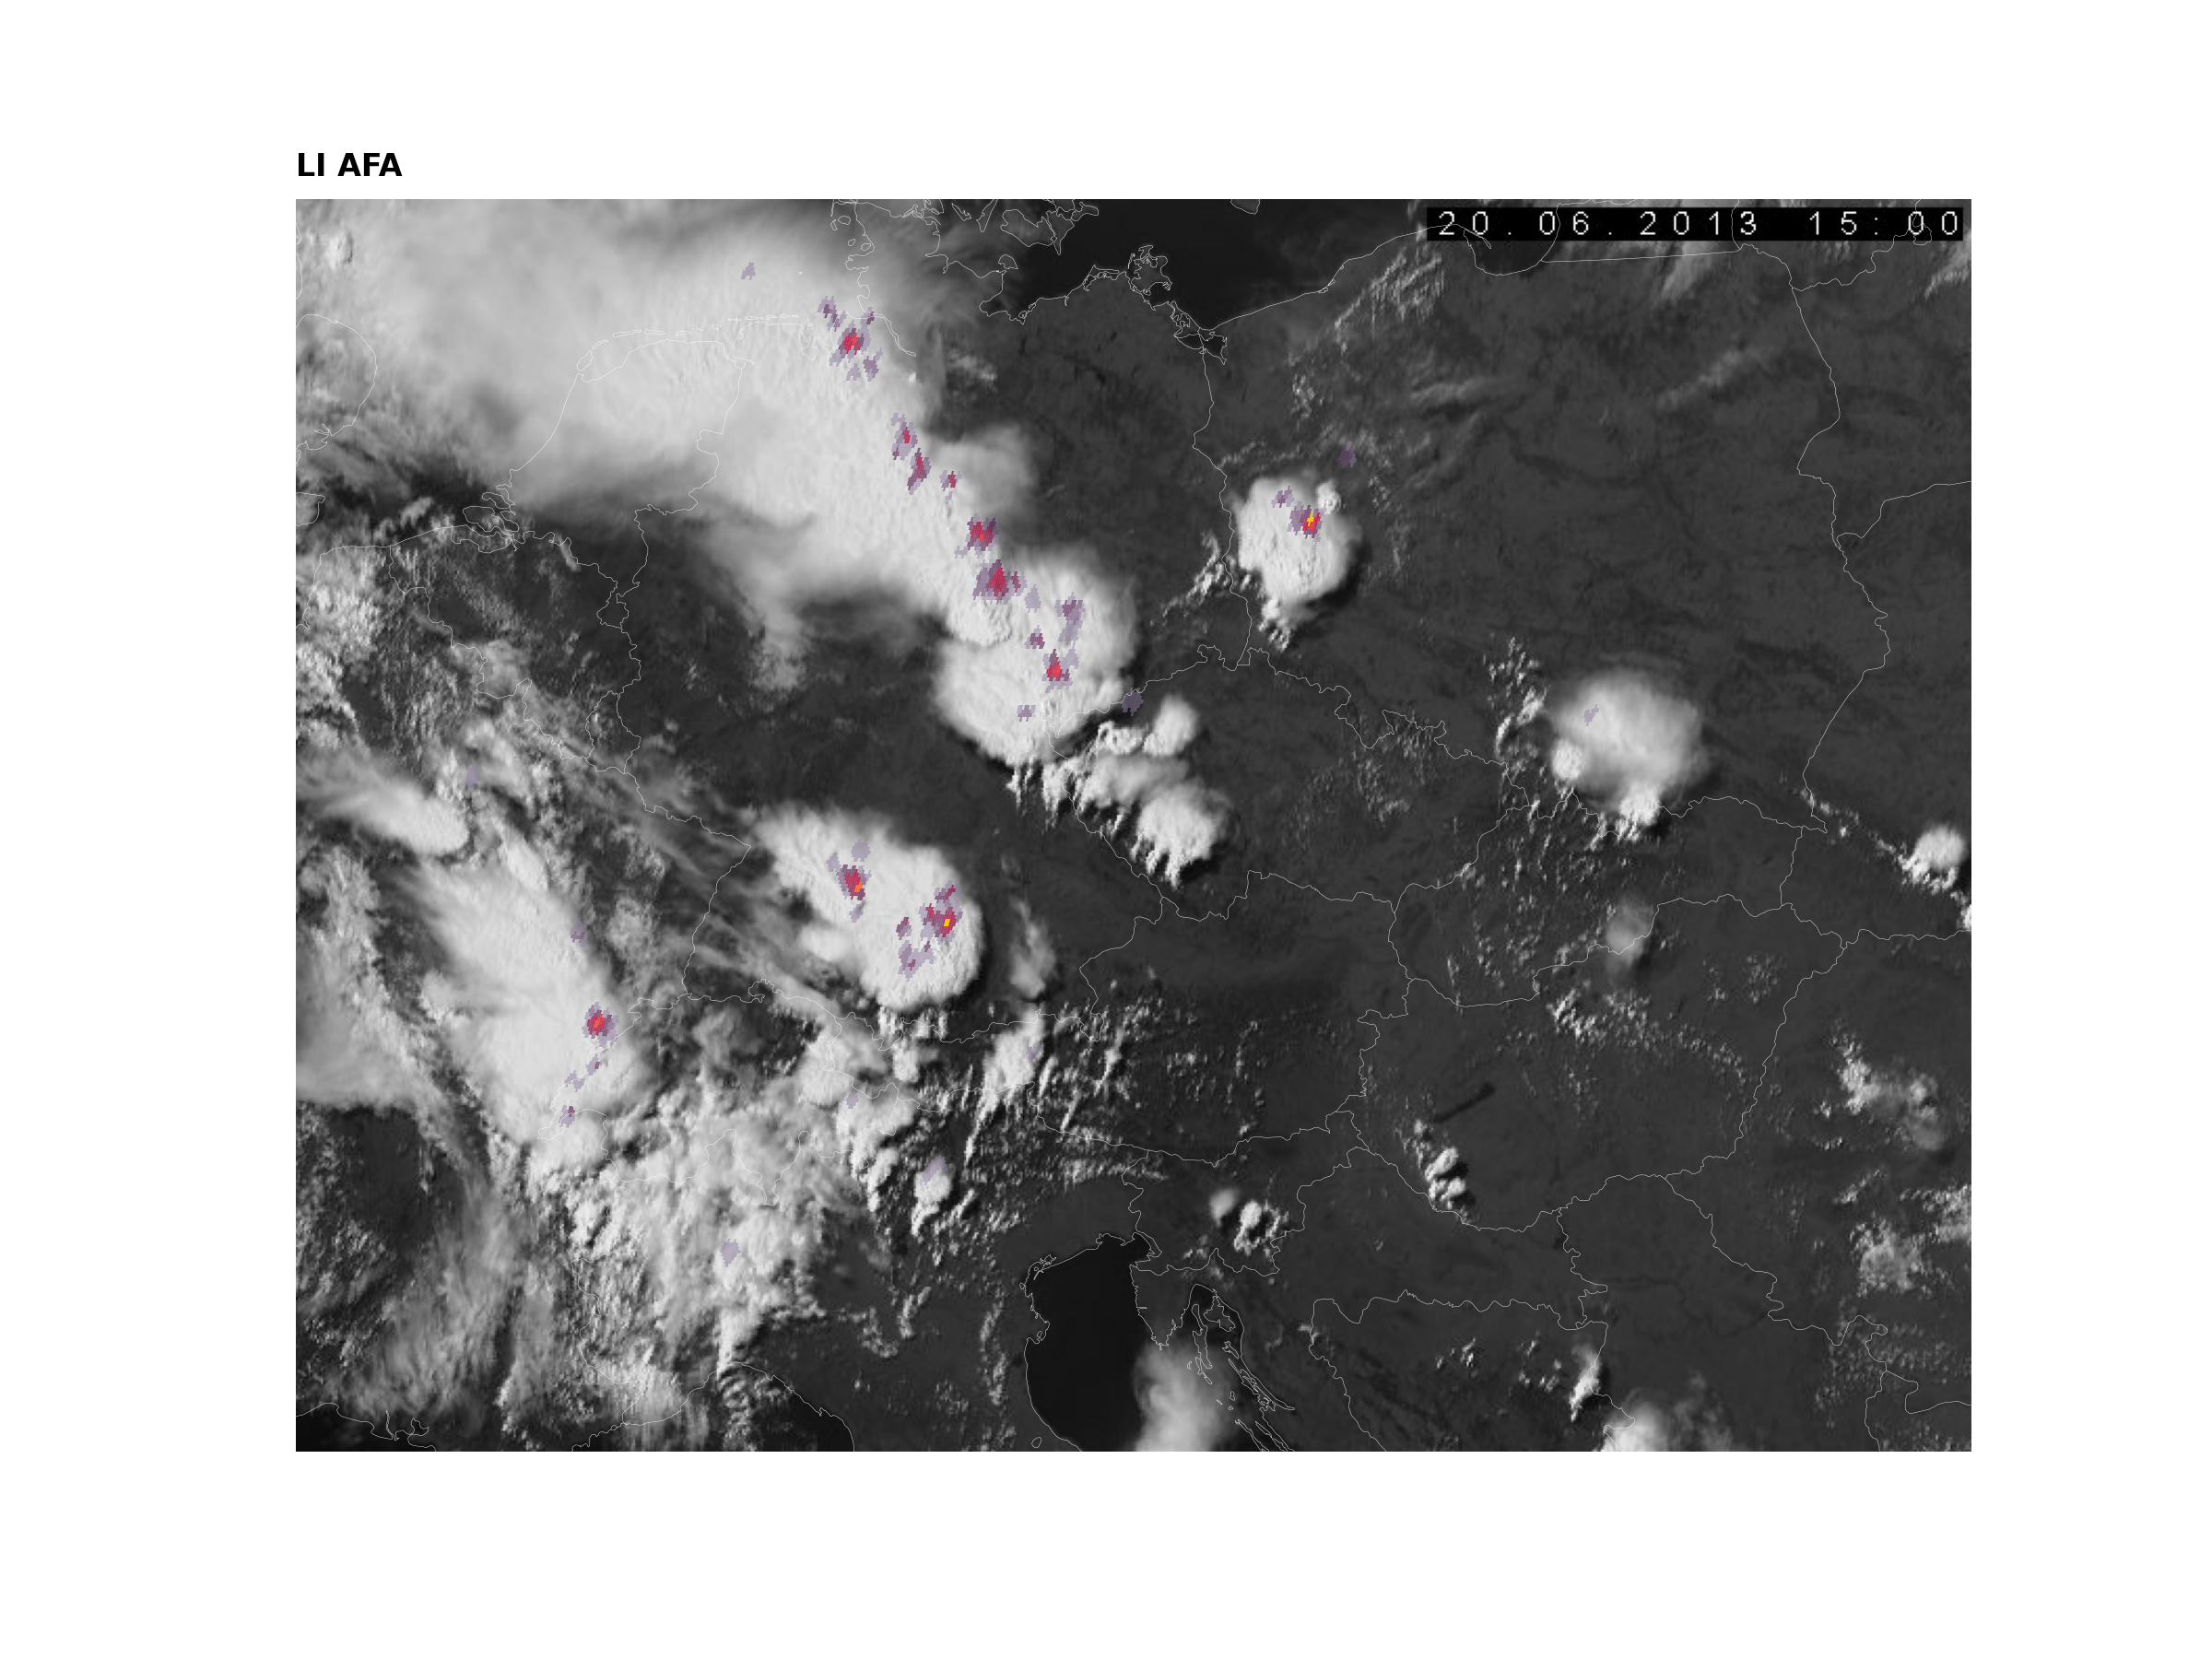

#### 1 Necessary imports and loading product files

In [1]:
import xarray as xr
from datetime import datetime, timedelta
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyproj import Proj
import cartopy
import cartopy.feature as cf
from glob import glob
import os

In [2]:
# Product file directory
file_dir = '/L2_run_flashes_201306201500_201306201501/'
os.chdir(file_dir)

# Loading dataset
for fname in glob('W_XX-EUMETSAT-DARMSTADT,IMG+SAT,MTI1+LI-2-AFA*'):
    file=fname
    ds=xr.open_dataset(file, decode_cf=False)

#### 2 Access some variables

In [3]:
# Earth radius
r_eq = float(ds.mtg_geos_projection.attrs['semi_major_axis'])
r_pol = float(ds.mtg_geos_projection.attrs['semi_minor_axis'])

# Satellite height + Earth radius
sat_h = float(ds.mtg_geos_projection.attrs['perspective_point_height'])

# Satellite longitude
sat_lon = float(ds.mtg_geos_projection.attrs['longitude_of_projection_origin'])

# Satellite sweep
sat_sweep = ds.mtg_geos_projection.attrs['sweep_angle_axis']

# Scale factor = Azimuth/Zenith grid sampling, same for 'x' and 'y'
scale_factor=ds.x.attrs['scale_factor']

# Add offset = azimuth and zenith angles from  the centre of the projection to the centre of the pixel
add_offset=ds.x.attrs['add_offset']

# Accumulated flash area; X -> azimuth index, Y -> zenith index
AFA = ds.accumulated_flash_area.values 
X = ds.x.values
Y = ds.y.values

#### 3 Localization of 1D flash accumulation data in 2D full disc

In [4]:
# Number of columns/rows in full disc
col = np.arange(1, 5569)
row = np.arange(1, 5569)

# Localize flash accumulation data in full disc grid
full_AFA = np.empty(col.shape + row.shape)
full_AFA.fill(np.nan)
full_AFA[Y, X] = AFA

#### 4 Latitude/longitude calculation from satellite radian angle vectors in full disk

In [5]:
# Calculation of all azimuth and zenith angles in full disc
a=-add_offset-(col-1)*scale_factor #negative from E to W
z=add_offset+(row-1)*scale_factor #negative from S to N

# Create meshgrid
aa, zz = np.meshgrid(a, z)

# lat/lon calculation routine
s4=(r_eq**2.0)/(r_pol**2.0)
s5=(sat_h**2.0)-(r_eq**2.0)
s_d=np.sqrt((sat_h*np.cos(aa)*np.cos(zz))**2-(np.cos(zz)**2.0+s4*(np.sin(zz)**2.0))*s5)
s_n=(sat_h*np.cos(aa)*np.cos(zz)-s_d)/((np.cos(zz))**2.0+s4*(np.sin(zz)**2.0))
s1=sat_h-s_n*np.cos(aa)*np.cos(zz)
s2=-s_n*np.sin(aa)*np.cos(zz)
s3=s_n*np.sin(zz)
s_xy=np.sqrt(s1**2.0+s2**2.0)
lon=(np.arctan(s2/s1)*180.0)/np.pi
lat=(np.arctan(s4*(s3/s_xy))*180.0)/np.pi

C:\ProgramData\Anaconda3\envs\LI_test\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


#### 5 Projecting the data

In [6]:
projection=cartopy.crs.Stereographic(central_latitude=90, central_longitude=15, 
                                     false_easting=1082174.131326, false_northing=4014747.106985)

# Corners
llx=0
lly=-1420239.633
urx=1899679.7888
ury=0

p=Proj(projection.proj4_init)
x,y = p(lon,lat)

# Replace inf values with zero
x0=np.nan_to_num(x, posinf=0)
y0=np.nan_to_num(y, posinf=0)

#### 6 Display figure

C:\ProgramData\Anaconda3\envs\LI_test\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  import sys
C:\ProgramData\Anaconda3\envs\LI_test\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  


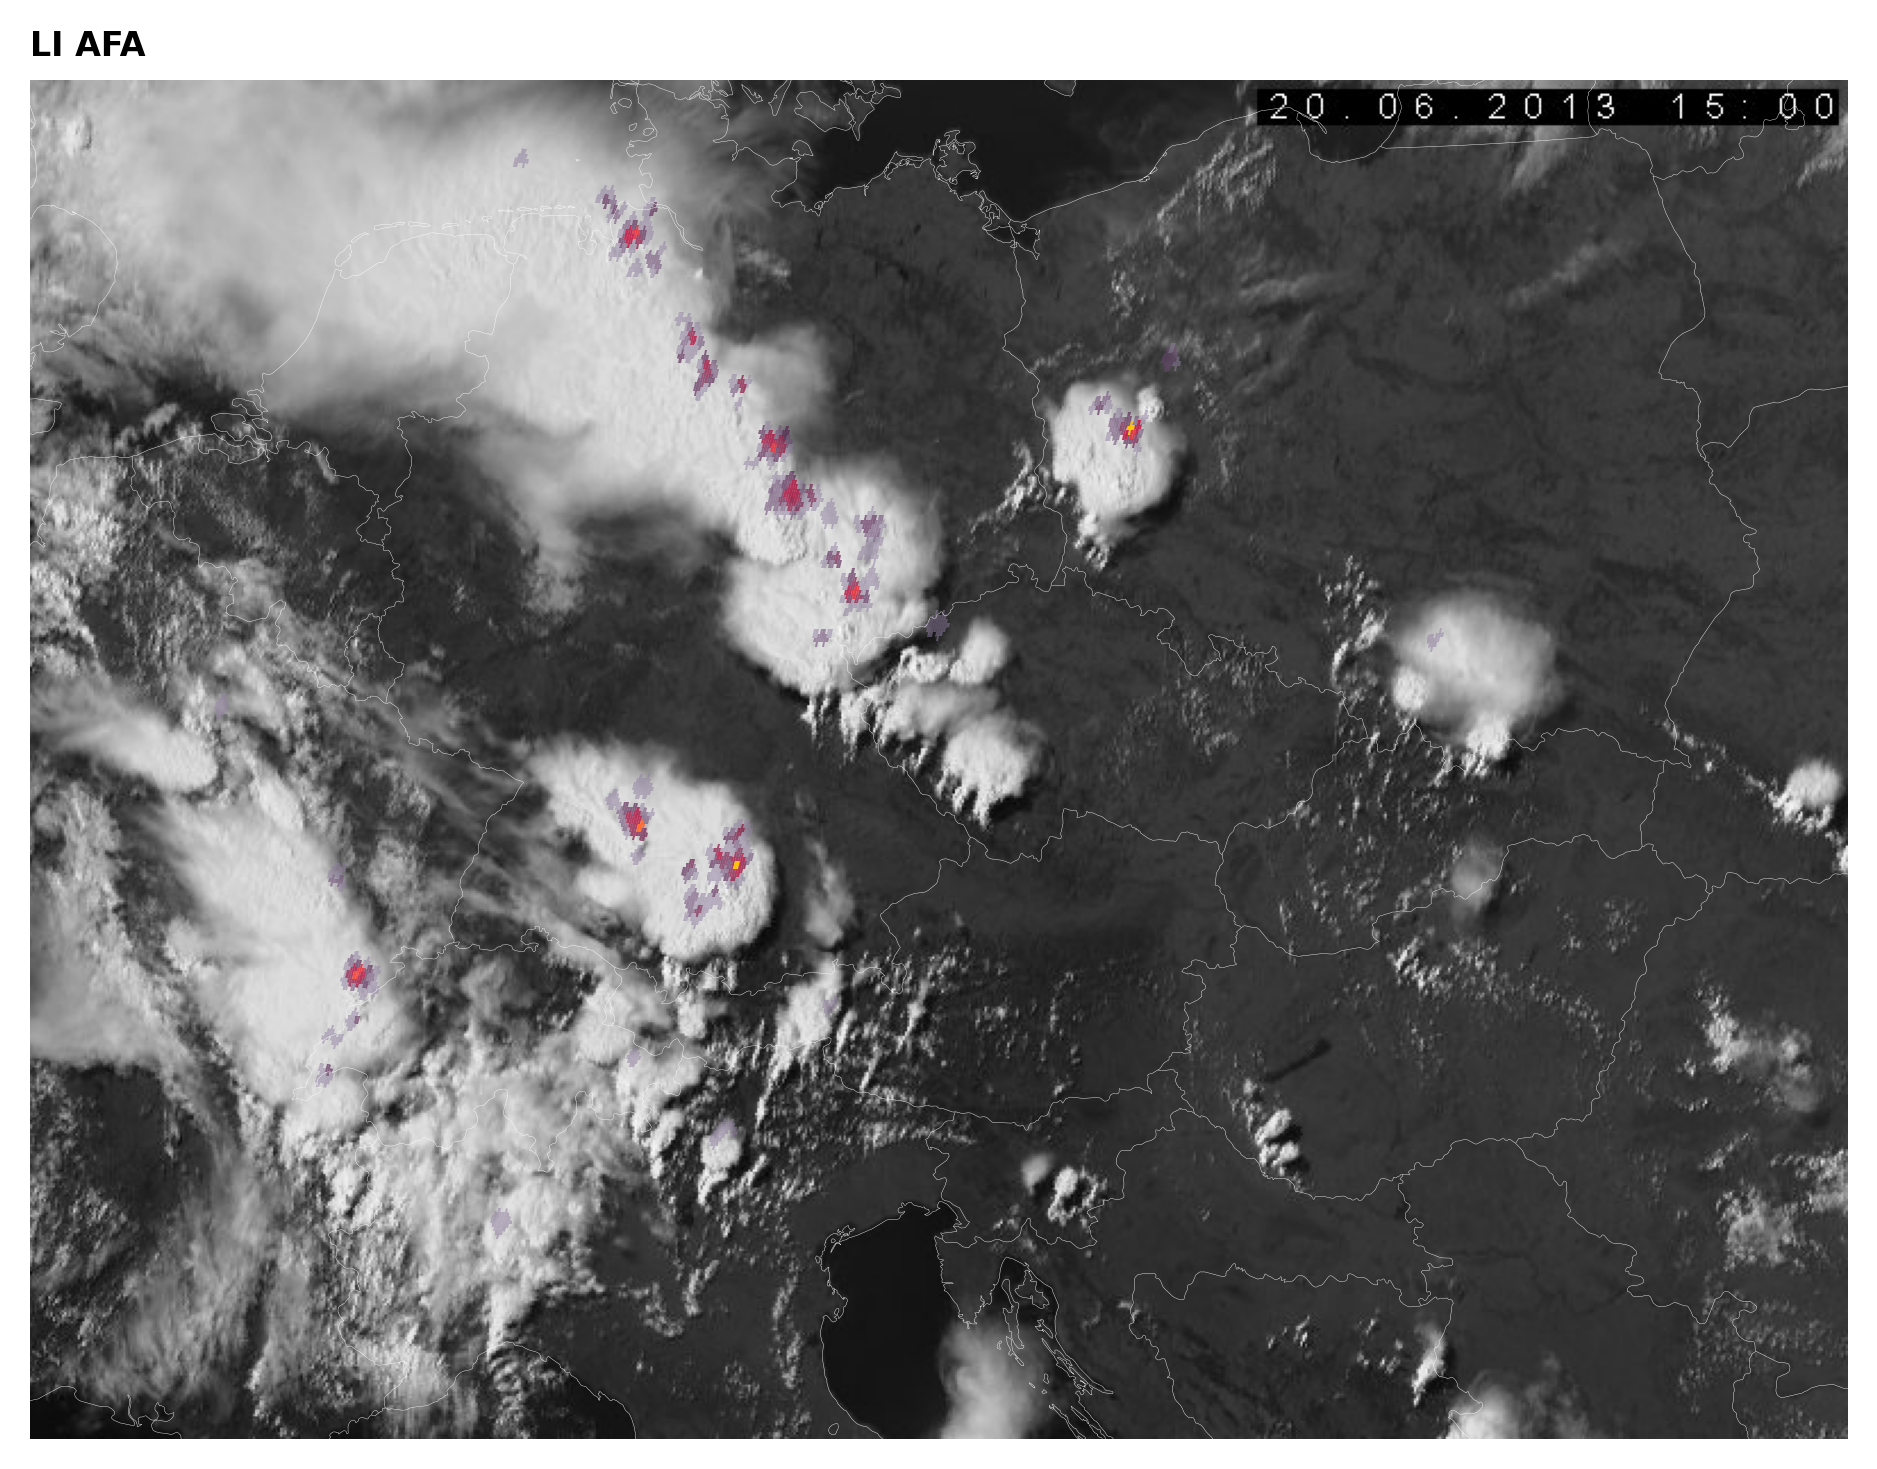

In [7]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_extent([ury, urx, lly, llx], crs=projection)
ax.add_feature(cf.COASTLINE, edgecolor='w', linewidth=0.1)
ax.add_feature(cf.BORDERS, edgecolor='w', linewidth=0.1)
ax.outline_patch.set_visible(False)
ax.background_patch.set_visible(False)

# Background image
image_filename='msgce.vis.20130620.1500.0.jpg'
img = plt.imread(image_filename)
img_extent = (llx, urx, lly, ury)
ax.imshow(img, origin="upper", extent=img_extent, transform=projection)

# Add accumulation flash data
colors=[(0.7,0.7,0.8,0.5), (0.3,0.1,0.3,0.6), (0.6,0.0,0.2,0.7), (0.8,0.0,0.2,0.8), 
        (1.0,0.3,0.2,0.9), (1.0,0.8,0.0,1.0), (1.0,1.0,0.0,1.0), (1.0,1.0,1.0,1.0)]
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=256)
plt.pcolor(x0, y0, full_AFA, transform=projection, cmap=cmap, snap=True, 
           edgecolors=(0,0,0,0.3), linewidth=0.000001, vmin=0, vmax=20)

plt.title('LI AFA', fontweight='semibold', loc='left', fontsize=8)
plt.savefig('afa.png')

#### 7 Compare to point flash data

At this point, there is some error in the position of gridded accumulated flash data, which appears to be shifted to the northeast relative to the point flash data.

In [8]:
# Reading the LI-L2-LFL files in the directory
latitude_lfl_tot = []
longitude_lfl_tot = []

for fname_lfl in glob('W_XX-EUMETSAT-DARMSTADT,IMG+SAT,MTI1+LI-2-LFL*'):
    file_lfl=fname_lfl
    data_lfl=xr.open_dataset(file_lfl)
    latitude_lfl = data_lfl.latitude.values
    latitude_lfl_tot.extend(latitude_lfl)
    longitude_lfl = data_lfl.longitude.values
    longitude_lfl_tot.extend(longitude_lfl)

# Projecting the data
x_lfl,y_lfl = p(longitude_lfl_tot,latitude_lfl_tot)

C:\ProgramData\Anaconda3\envs\LI_test\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  import sys
C:\ProgramData\Anaconda3\envs\LI_test\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  


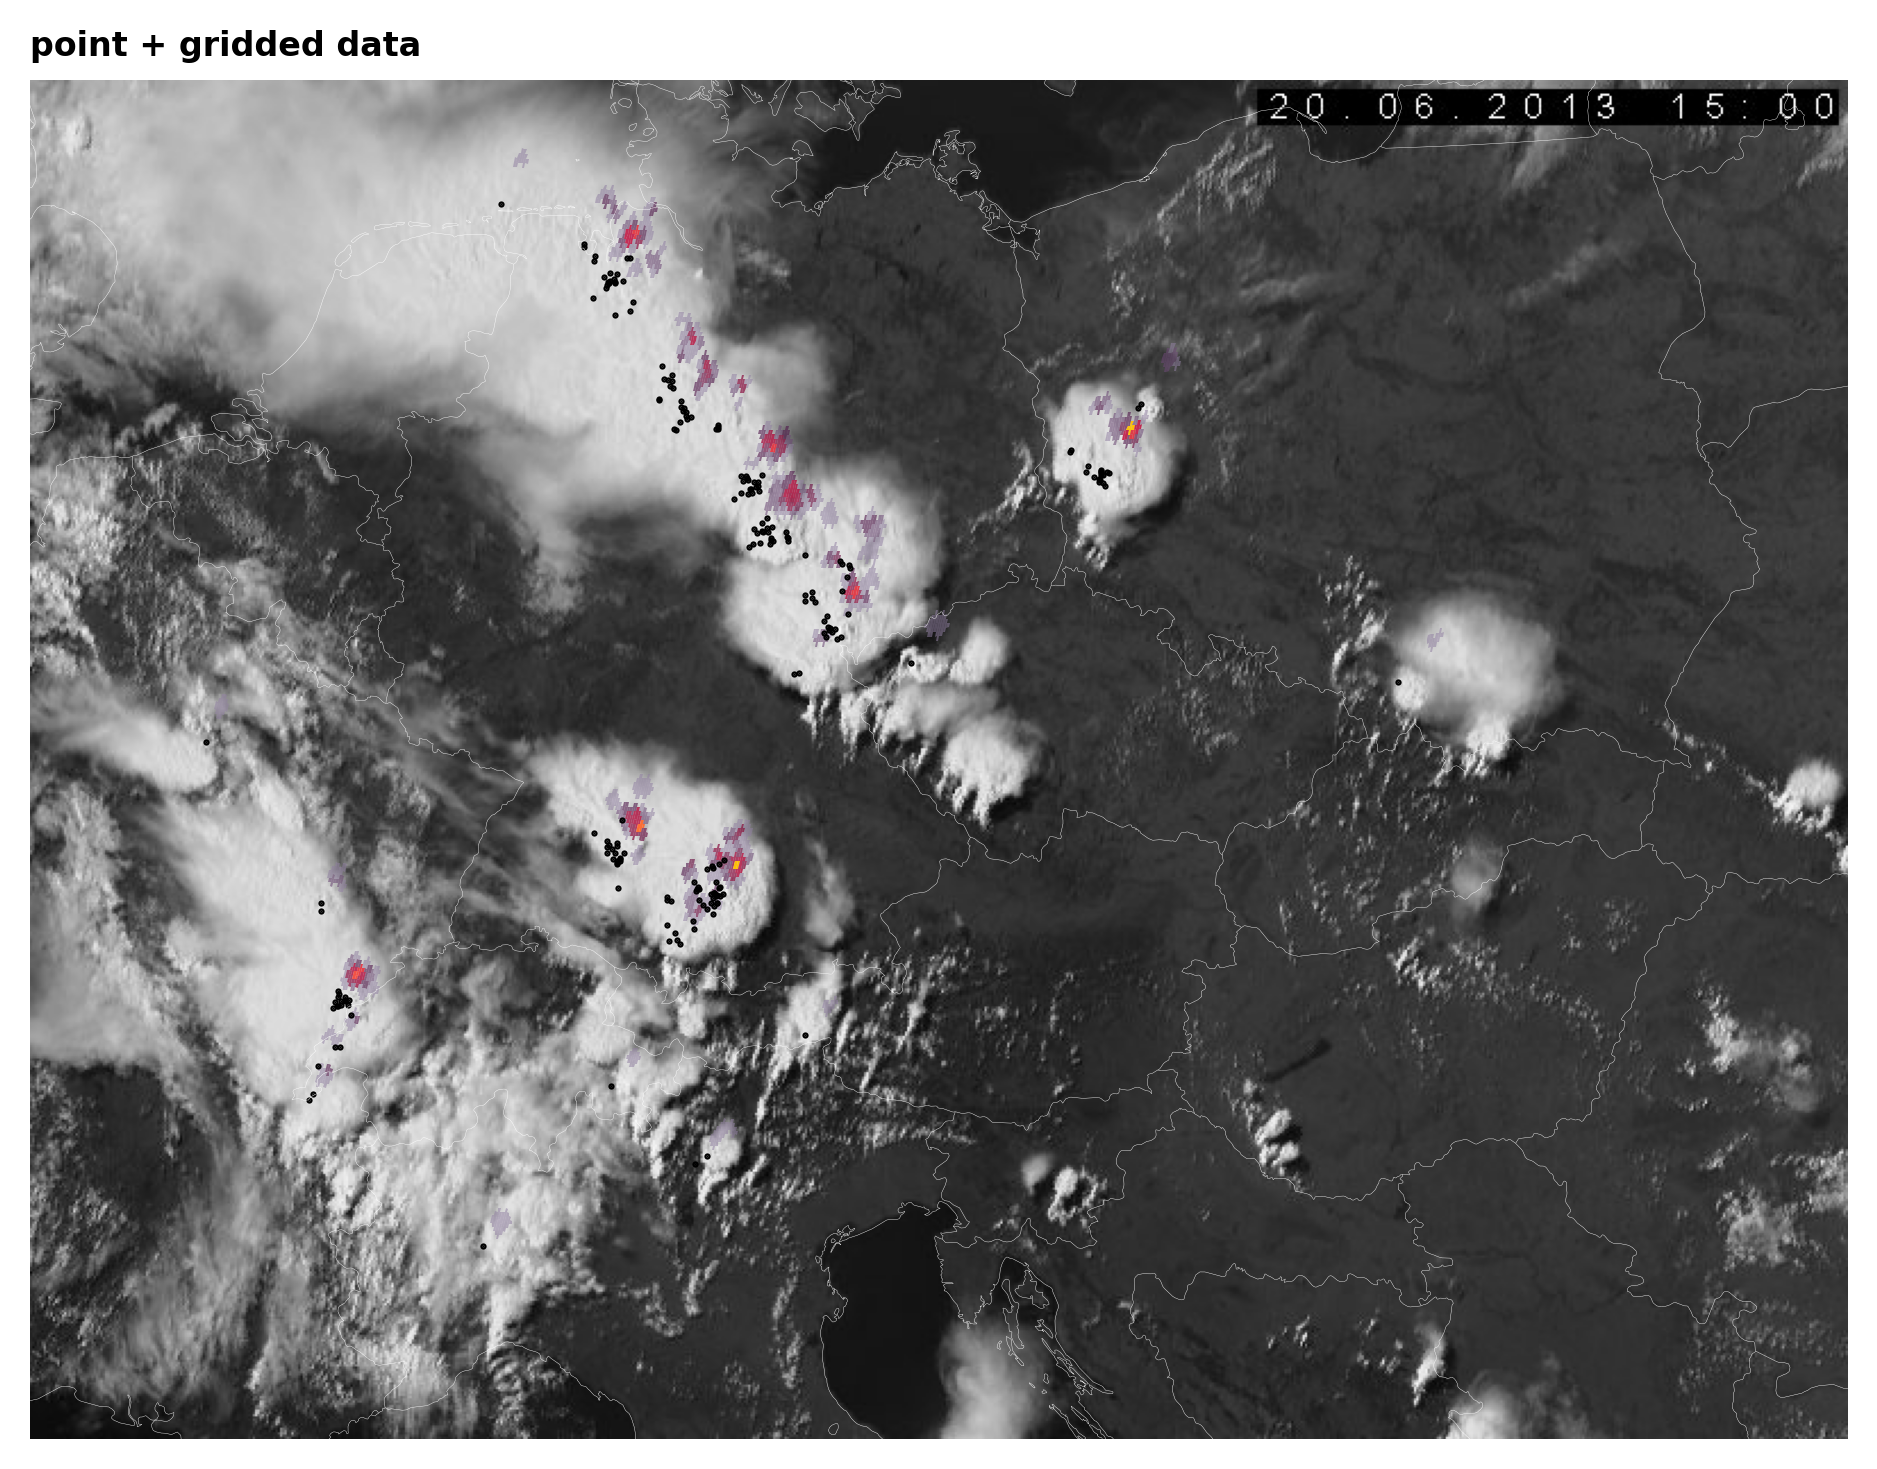

In [9]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_extent([ury, urx, lly, llx], crs=projection)
ax.add_feature(cf.COASTLINE, edgecolor='w', linewidth=0.1)
ax.add_feature(cf.BORDERS, edgecolor='w', linewidth=0.1)
ax.outline_patch.set_visible(False)
ax.background_patch.set_visible(False)

# Background image
image_filename='msgce.vis.20130620.1500.0.jpg'
img = plt.imread(image_filename)
img_extent = (llx, urx, lly, ury)
ax.imshow(img, origin="upper", extent=img_extent, transform=projection)

# Add accumulation flash data
colors=[(0.7,0.7,0.8,0.5), (0.3,0.1,0.3,0.6), (0.6,0.0,0.2,0.7), (0.8,0.0,0.2,0.8), 
        (1.0,0.3,0.2,0.9), (1.0,0.8,0.0,1.0), (1.0,1.0,0.0,1.0), (1.0,1.0,1.0,1.0)]
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=256)
plt.pcolor(x0, y0, full_AFA, transform=projection, cmap=cmap, snap=True, 
           edgecolors=(0,0,0,0.3), linewidth=0.000001, vmin=0, vmax=20)

# Add point flash data
plt.scatter(x_lfl, y_lfl, color="k", marker=".", s=1, transform=projection)

plt.title('point + gridded data', fontweight='semibold', loc='left', fontsize=8)
plt.savefig('afa_lfl.png')